## Yelp Review Rating Prediction with 4 Prompting Approaches

**Task 1 – Rating Prediction via Prompting**

Design prompts that classify Yelp reviews into 1–5 star ratings, returning structured JSON.

### Overview
Implemented 4 different prompting approaches:
1. **Direct Sentiment Mapping** - Simple, baseline approach
2. **Aspect-Aware Reasoning** - Evaluates multiple aspects (service, quality, price, etc.)
3. **Few-Shot with Calibration** - Uses examples for each star level
4. **Chain-of-Thought Reasoning** - Structured reasoning steps

### Output Format
```json
{
  "predicted_stars": 4,
  "explanation": "Brief reasoning for the assigned rating."
}
```

In [1]:
# !pip install langchain>=0.1.0 \
#     langchain-openai>=0.1.0 \
#     langchain-community>=0.1.0 \
#     openai>=1.3.0 \
#     "numpy>=1.24.0,<2.0.0" \
#     pydantic>=2.0.0 \
#     pydantic-settings>=2.0.0 \
#     requests>=2.31.0 \
#     lxml>=4.9.0 \
#     python-dotenv>=1.0.0 \
#     python-multipart>=0.0.6 \
#     loguru>=0.7.0 \
#     httpx>=0.25.0 \
#     aiofiles>=23.0.0 \
#     validators>=0.22.0 \
#     pandas \
#     matplotlib \
#     seaborn \
#     scikit-learn

In [2]:
import pandas as pd
import numpy as np
import json
import logging
import time
import os
from typing import List, Dict, Any, Tuple
from datetime import datetime
from pathlib import Path
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field, ConfigDict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    mean_absolute_error, 
    confusion_matrix,
    classification_report
)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('yelp_prediction.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [ ]:
os.environ["OPENAI_API_KEY"] = "sk-proj-6SWn......"

### Pydantic Schemas for Structured Output

In [4]:
class ReviewPrediction(BaseModel):
    """Single review prediction schema"""
    model_config = ConfigDict(extra='forbid')
    review_id: str = Field(description="Unique identifier for the review")
    predicted_stars: int = Field(ge=1, le=5, description="Predicted star rating (1-5)")
    explanation: str = Field(
        min_length=15,
        max_length=200,
        description="Brief reasoning for the assigned rating"
    )

class BatchPredictions(BaseModel):
    """Batch of review predictions"""
    predictions: List[ReviewPrediction] = Field(
        description="List of predictions for all reviews in batch"
    )

### Prompt Templates

#### Four Different Prompting Approaches:

1. **PROMPT_V1_DIRECT** - Direct sentiment mapping (baseline)
2. **PROMPT_V2_ASPECT_AWARE** - Evaluates key aspects before rating
3. **PROMPT_V3_FEW_SHOT** - Uses calibration examples for each star level
4. **PROMPT_V4_CHAIN_OF_THOUGHT** - Structured reasoning chain

In [5]:
PROMPT_V1_DIRECT = """You are an expert at analyzing Yelp reviews and predicting star ratings.

TASK: Predict the star rating (1-5) for each review based on the overall sentiment and tone.

RATING SCALE:
- 1 star: Extremely negative, terrible experience
- 2 stars: Negative, disappointed, below expectations
- 3 stars: Neutral/mixed, average experience
- 4 stars: Positive, satisfied, good experience
- 5 stars: Extremely positive, exceeded expectations, excellent

CRITICAL INSTRUCTIONS:
- Treat each review INDEPENDENTLY - do not let previous reviews influence your judgment
- Return predictions in the EXACT order they appear below
- Focus on overall sentiment and emotional tone
- Keep explanations concise (15-50 words)

REVIEWS TO ANALYZE:
{reviews_json}

Provide your predictions in the structured format."""

print("Prompt V1 (Direct) loaded")

Prompt V1 (Direct) loaded


In [6]:
PROMPT_V2_ASPECT_AWARE = """You are an expert at analyzing Yelp reviews by evaluating multiple aspects of customer experience.

TASK: Predict the star rating (1-5) for each review by considering key aspects.

KEY ASPECTS TO CONSIDER:
1. Service Quality: Staff friendliness, attentiveness, professionalism
2. Product/Food Quality: Taste, freshness, presentation, correctness
3. Price/Value: Whether experience was worth the cost
4. Cleanliness: Hygiene standards, maintenance
5. Wait Time: Service speed, delays
6. Problem Resolution: How complaints were handled
7. Atmosphere: Ambience, comfort, environment

RATING GUIDELINES:
- 1 star: Multiple major failures (bad service + bad quality + expensive)
- 2 stars: One major failure or multiple minor issues
- 3 stars: Mixed aspects (some good, some bad) or just acceptable
- 4 stars: Mostly positive aspects with minor issues
- 5 stars: Excellent across all mentioned aspects

CRITICAL INSTRUCTIONS:
- Mentally evaluate each aspect mentioned in the review
- Weigh negative aspects more heavily (service failures strongly impact ratings)
- Treat each review INDEPENDENTLY
- Return predictions in the EXACT order received
- Explanations should reference specific aspects (e.g., "Poor service quality")

REVIEWS TO ANALYZE:
{reviews_json}

Provide your predictions in the structured format."""

print("Prompt V2 (Aspect-Aware) loaded")

Prompt V2 (Aspect-Aware) loaded


In [7]:
PROMPT_V3_FEW_SHOT = """You are an expert at analyzing Yelp reviews and predicting star ratings.

CALIBRATION EXAMPLES - Learn what each star level looks like:

1-STAR Example:
"Terrible experience. Food was cold, staff was incredibly rude, and we waited forever. The place was dirty too. Completely unacceptable. Never returning."
→ Rating: 1 star (Multiple critical failures)

2-STAR Example:
"Disappointing visit. The food was okay but nothing special. Service was slow and inattentive. Overpriced for what we got. Expected more based on reviews."
→ Rating: 2 stars (Below expectations, some problems)

3-STAR Example:
"Average experience. Food was decent, service was fine. Nothing stood out as great or terrible. It's okay if you're in the area but wouldn't go out of my way."
→ Rating: 3 stars (Acceptable but unremarkable)

4-STAR Example:
"Really enjoyed our visit! Food was delicious and fresh. Staff was friendly and attentive. Had to wait about 15 minutes but it was worth it. Would definitely come back."
→ Rating: 4 stars (Very good with minor flaws)

5-STAR Example:
"Absolutely perfect experience! Best meal I've had in months. Service was impeccable - attentive without being intrusive. Beautiful atmosphere. Can't wait to return!"
→ Rating: 5 stars (Exceptional, exceeded expectations)

TASK: Now classify these reviews using the same calibration:

CRITICAL INSTRUCTIONS:
- Use the examples above as anchor points for each rating level
- Match the tone and language intensity to the appropriate star level
- Treat each review INDEPENDENTLY
- Return predictions in the EXACT order received
- Reference the calibration level in your explanation

REVIEWS TO ANALYZE:
{reviews_json}

Provide your predictions in the structured format."""

print("Prompt V3 (Few-Shot) loaded")

Prompt V3 (Few-Shot) loaded


In [8]:
PROMPT_V4_CHAIN_OF_THOUGHT = """You are an expert at analyzing Yelp reviews using structured reasoning.

TASK: For each review, follow this reasoning chain to predict the star rating (1-5).

REASONING STEPS (mental process - don't output these, just use them):
Step 1: Identify main sentiment (Very Positive / Positive / Mixed / Negative / Very Negative)
Step 2: List key aspects mentioned and their polarity
   - Service: positive/neutral/negative
   - Quality: positive/neutral/negative  
   - Price/Value: positive/neutral/negative
   - Other aspects: positive/neutral/negative
Step 3: Identify deal-breakers (critical failures) or highlights (exceptional experiences)
Step 4: Consider language intensity (enthusiastic? disappointed? angry? satisfied?)
Step 5: Synthesize into final rating

RATING DECISION LOGIC:
- Very Negative sentiment + deal-breakers → 1 star
- Negative sentiment + problems → 2 stars
- Mixed sentiment OR neutral/average → 3 stars
- Positive sentiment + mostly good → 4 stars
- Very Positive sentiment + highlights → 5 stars

CRITICAL INSTRUCTIONS:
- Apply this reasoning chain to EACH review independently
- Your explanation should reflect the key reasoning (e.g., "Negative service and quality issues")
- Don't let previous reviews bias your judgment
- Return predictions in the EXACT order received
- Be consistent in applying the decision logic

REVIEWS TO ANALYZE:
{reviews_json}

Provide your predictions in the structured format."""

print("Prompt V4 (Chain-of-Thought) loaded")

Prompt V4 (Chain-of-Thought) loaded


In [9]:
def prepare_batch_input(reviews: List[Dict[str, str]]) -> str:
    """Prepare reviews for batch processing"""
    formatted_reviews = []
    for idx, review in enumerate(reviews, 1):
        formatted_reviews.append(
            f"Review {idx} [ID: {review['review_id']}]:\n{review['text']}\n"
        )
    return "\n".join(formatted_reviews)

def predict_batch(
    reviews: List[Dict[str, str]], 
    prompt_template: str,
    model_name: str = "gpt-4o-mini",
    temperature: float = 0.0
) -> List[Dict[str, Any]]:
    """
    Predict ratings for a batch of reviews with structured output
    
    Args:
        reviews: List of dicts with 'review_id' and 'text'
        prompt_template: Prompt template string
        model_name: OpenAI model name
        temperature: Sampling temperature
    
    Returns:
        List of prediction dicts
    """
    llm = ChatOpenAI(
        model=model_name,
        temperature=temperature
    ).with_structured_output(BatchPredictions)
    
    reviews_json = prepare_batch_input(reviews)
    prompt = ChatPromptTemplate.from_template(prompt_template)
    chain = prompt | llm
    result = chain.invoke({"reviews_json": reviews_json})
    predictions = [pred.model_dump() for pred in result.predictions]
    if len(predictions) != len(reviews):
        logger.warning(
            f"Expected {len(reviews)} predictions, got {len(predictions)}"
        )
    
    return predictions

### Evaluation Metrics

Functions to calculate accuracy, MAE, within ±1 accuracy, and per-class metrics.

In [10]:
def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calculate comprehensive evaluation metrics
    
    Metrics:
    - Exact Match Accuracy: Percentage of exact predictions
    - Within ±1 Star: Percentage of predictions within 1 star
    - Mean Absolute Error (MAE): Average magnitude of errors
    """
    mask = y_pred > 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    if len(y_pred_filtered) == 0:
        return {
            'exact_match_accuracy': 0.0,
            'within_1_star_accuracy': 0.0,
            'mean_absolute_error': 0.0,
            'valid_predictions': 0,
            'failed_predictions': len(y_pred) - len(y_pred_filtered)
        }
    exact_match = accuracy_score(y_true_filtered, y_pred_filtered)
    within_1 = np.mean(np.abs(y_true_filtered - y_pred_filtered) <= 1)
    mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
    
    return {
        'exact_match_accuracy': exact_match,
        'within_1_star_accuracy': within_1,
        'mean_absolute_error': mae,
        'valid_predictions': len(y_pred_filtered),
        'failed_predictions': len(y_pred) - len(y_pred_filtered)
    }

def calculate_per_class_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> pd.DataFrame:
    """Calculate precision, recall, F1 for each star rating"""
    mask = y_pred > 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    if len(y_pred_filtered) == 0:
        return pd.DataFrame()
    report = classification_report(
        y_true_filtered, 
        y_pred_filtered, 
        labels=[1, 2, 3, 4, 5],
        output_dict=True,
        zero_division=0
    )
    
    df_metrics = pd.DataFrame({
        'Star Rating': [1, 2, 3, 4, 5],
        'Precision': [report[str(i)]['precision'] for i in range(1, 6)],
        'Recall': [report[str(i)]['recall'] for i in range(1, 6)],
        'F1-Score': [report[str(i)]['f1-score'] for i in range(1, 6)],
        'Support': [report[str(i)]['support'] for i in range(1, 6)]
    })
    
    return df_metrics

### Batch Processing Pipeline

In [11]:
def create_batches(data: List[Dict], batch_size: int = 7) -> List[List[Dict]]:
    """Split data into batches"""
    return [data[i:i+batch_size] for i in range(0, len(data), batch_size)]

def process_all_reviews(
    df: pd.DataFrame,
    prompt_template: str,
    prompt_version: str,
    output_csv: str,
    batch_size: int = 7,
    sample_size: int = 200
):
    """
    pipeline for processing reviews with one prompt version
    
    Args:
        df: Input dataframe
        prompt_template: Prompt template string
        prompt_version: Version identifier (e.g., 'prompt1')
        output_csv: Path to output CSV
        batch_size: Reviews per batch
        sample_size: Total reviews to process
    """
    logger.info(f"\n{'='*70}")
    logger.info(f"STARTING {prompt_version.upper()}")
    logger.info(f"{'='*70}")
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
    
    reviews_data = [
        {
            'review_id': row['review_id'],
            'text': row['text'][:1000],
            'original_stars': row['stars']
        }
        for _, row in df_sample.iterrows()
    ]
    
    batches = create_batches(reviews_data, batch_size)
    logger.info(f"Created {len(batches)} batches of size {batch_size}")
    all_results = []
    
    for batch_idx, batch in enumerate(batches, 1):
        logger.info(f"\n Batch {batch_idx}/{len(batches)} ---")
        
        try:
            logger.info(f"Processing batch of {len(batch)} reviews")
            predictions = predict_batch(batch, prompt_template)
            if len(predictions) != len(batch):
                logger.error(f"Expected {len(batch)} predictions, got {len(predictions)}")
                raise ValueError("Incomplete predictions")
            
            logger.info(f"Batch successful: {len(predictions)} predictions")
            for review, pred in zip(batch, predictions):
                result = {
                    'review_id': review['review_id'],
                    'text': review['text'],
                    'original_stars': review['original_stars'],
                    f'{prompt_version}_predicted_stars': pred['predicted_stars'],
                    f'{prompt_version}_explanation': pred['explanation']
                }
                all_results.append(result)
            results_df = pd.DataFrame(all_results)
            results_df.to_csv(output_csv, index=False)
            logger.info(f"Saved {len(all_results)} results to {output_csv}")
            time.sleep(1)
            
        except Exception as e:
            logger.error(f"Critical error in batch {batch_idx}: {e}")
            for review in batch:
                result = {
                    'review_id': review['review_id'],
                    'text': review['text'],
                    'original_stars': review['original_stars'],
                    f'{prompt_version}_predicted_stars': -1,
                    f'{prompt_version}_explanation': f"BATCH FAILED: {str(e)}"
                }
                all_results.append(result)
            continue
    
    logger.info(f"done {prompt_version.upper()}: {len(all_results)} reviews processed")
    
    return pd.DataFrame(all_results)

### Merge Results from All Prompts

In [12]:
def merge_all_prompt_results(output_path: str = "review_prompts.csv"):
    logger.info("Merging all prompt results...")
    
    files = [
        'results_prompt1.csv',
        'results_prompt2.csv', 
        'results_prompt3.csv',
        'results_prompt4.csv'
    ]
    
    df_merged = pd.read_csv(files[0])
    for file in files[1:]:
        try:
            df_temp = pd.read_csv(file)
            pred_cols = [col for col in df_temp.columns if 'prompt' in col]
            df_merged = df_merged.merge(
                df_temp[['review_id'] + pred_cols],
                on='review_id',
                how='left'
            )
        except Exception as e:
            logger.error(f"Failed to merge {file}: {e}")
    final_cols = ['review_id', 'text', 'original_stars']
    for i in range(1, 5):
        final_cols.extend([
            f'prompt{i}_predicted_stars',
            f'prompt{i}_explanation'
        ])
    
    df_merged = df_merged[final_cols]
    df_merged.to_csv(output_path, index=False)
    
    logger.info(f"Final merged results saved to {output_path}")
    logger.info(f"  Total reviews: {len(df_merged)}")
    logger.info(f"  Columns: {list(df_merged.columns)}")
    
    return df_merged

### Evaluation and Visualization

Functions to evaluate all prompts

In [13]:
def evaluate_all_prompts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate comprehensive metrics for all prompt versions
    
    Returns:
        DataFrame with metrics comparison
    """
    logger.info("CALCULATING COMPREHENSIVE METRICS")
    
    metrics_list = []
    
    for i in range(1, 5):
        pred_col = f'prompt{i}_predicted_stars'
        
        if pred_col not in df.columns:
            logger.warning(f"Column {pred_col} not found")
            continue
        
        y_true = df['original_stars'].values
        y_pred = df[pred_col].values
        metrics = calculate_metrics(y_true, y_pred)
        metrics['prompt_version'] = f'Prompt {i}'
        metrics_list.append(metrics)
        logger.info(f"\n{metrics['prompt_version']}:")
        logger.info(f"  Exact Match: {metrics['exact_match_accuracy']:.2%}")
        logger.info(f"  Within ±1: {metrics['within_1_star_accuracy']:.2%}")
        logger.info(f"  MAE: {metrics['mean_absolute_error']:.3f}")
        logger.info(f"  Valid: {metrics['valid_predictions']}, Failed: {metrics['failed_predictions']}")
    
    df_metrics = pd.DataFrame(metrics_list)
    df_metrics = df_metrics[[
        'prompt_version', 
        'exact_match_accuracy', 
        'within_1_star_accuracy',
        'mean_absolute_error',
        'valid_predictions',
        'failed_predictions'
    ]]
    df_metrics.to_csv('metrics_comparison.csv', index=False)
    logger.info(f"\nMetrics save")
    return df_metrics

In [14]:
def plot_comparison_charts(df: pd.DataFrame, df_metrics: pd.DataFrame):
    logger.info("GENERATING VISUALIZATION CHARTS")
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    fig = plt.figure(figsize=(18, 12))
    ax1 = plt.subplot(2, 3, 1)
    x = np.arange(len(df_metrics))
    width = 0.35
    bars1 = ax1.bar(x - width/2, df_metrics['exact_match_accuracy'] * 100, 
                    width, label='Exact Match', alpha=0.8)
    bars2 = ax1.bar(x + width/2, df_metrics['within_1_star_accuracy'] * 100, 
                    width, label='Within ±1 Star', alpha=0.8)
    
    ax1.set_xlabel('Prompt Version', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy Comparison Across Prompts', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_metrics['prompt_version'])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    

    ax2 = plt.subplot(2, 3, 2)
    
    bars = ax2.bar(df_metrics['prompt_version'], df_metrics['mean_absolute_error'],
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], alpha=0.8)
    
    ax2.set_xlabel('Prompt Version', fontsize=12, fontweight='bold')
    ax2.set_ylabel('MAE (Lower is Better)', fontsize=12, fontweight='bold')
    ax2.set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    ax3 = plt.subplot(2, 3, 3)
    
    best_prompt_idx = df_metrics['exact_match_accuracy'].idxmax()
    best_prompt_num = best_prompt_idx + 1
    best_prompt_col = f'prompt{best_prompt_num}_predicted_stars'
    
    y_true = df['original_stars'].values
    y_pred = df[best_prompt_col].values
    mask = y_pred > 0
    cm = confusion_matrix(y_true[mask], y_pred[mask], labels=[1, 2, 3, 4, 5])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    ax3.set_xlabel('Predicted Stars', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Actual Stars', fontsize=12, fontweight='bold')
    ax3.set_title(f'Confusion Matrix - Prompt {best_prompt_num} (Best)', 
                  fontsize=14, fontweight='bold')
    
    ax4 = plt.subplot(2, 3, 4)

    original_dist = df['original_stars'].value_counts().sort_index()
    
    ax4.plot(original_dist.index, original_dist.values, 
             marker='o', linewidth=3, markersize=10, label='Original', color='black')
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    for i in range(1, 5):
        pred_col = f'prompt{i}_predicted_stars'
        if pred_col in df.columns:
            pred_dist = df[df[pred_col] > 0][pred_col].value_counts().sort_index()
            ax4.plot(pred_dist.index, pred_dist.values, 
                    marker='s', linewidth=2, markersize=8, 
                    label=f'Prompt {i}', alpha=0.7, color=colors[i-1])
    
    ax4.set_xlabel('Star Rating', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax4.set_title('Star Rating Distribution Comparison', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    ax5 = plt.subplot(2, 3, (5, 6)) 
    ax5.axis('tight')
    ax5.axis('off')
    table_data = []
    for _, row in df_metrics.iterrows():
        table_data.append([
            row['prompt_version'],
            f"{row['exact_match_accuracy']:.1%}",
            f"{row['within_1_star_accuracy']:.1%}",
            f"{row['mean_absolute_error']:.3f}"
        ])
    
    table = ax5.table(cellText=table_data,
                     colLabels=['Prompt', 'Exact Match', '±1 Star', 'MAE'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.25, 0.25, 0.25, 0.25])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    for i in range(4):
        table[(0, i)].set_facecolor('#4ECDC4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    best_exact = df_metrics['exact_match_accuracy'].max()
    best_within1 = df_metrics['within_1_star_accuracy'].max()
    best_mae = df_metrics['mean_absolute_error'].min()
    
    for i, row in enumerate(table_data, start=1):
        if f"{best_exact:.1%}" in row[1]:
            table[(i, 1)].set_facecolor('#90EE90')
        if f"{best_within1:.1%}" in row[2]:
            table[(i, 2)].set_facecolor('#90EE90')
        if f"{best_mae:.3f}" in row[3]:
            table[(i, 3)].set_facecolor('#90EE90')
    
    ax5.set_title('Metrics Summary (Green = Best)', fontsize=14, fontweight='bold', pad=20)
    plt.suptitle('Yelp Review Rating Prediction - Prompt Comparison Analysis', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('prompt_comparison_analysis.png', dpi=300, bbox_inches='tight')
    logger.info("Visualization saved to prompt_comparison_analysis.png")
    
    plt.show()
    
    return fig


In [15]:
# Configuration
DATA_PATH = "yelp.csv"
BATCH_SIZE = 7
SAMPLE_SIZE = 200
df = pd.read_csv(DATA_PATH)
print(f"{len(df)} reviews")
print(f"  Columns: {list(df.columns)}")
required_cols = ['review_id', 'text', 'stars']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")
df = df.dropna(subset=['text', 'stars'])
df['text'] = df['text'].astype(str)

10000 reviews
  Columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']


### Run Prompt Version 1: Direct Sentiment Mapping

**Approach**: Simple, baseline approach - directly maps sentiment to star rating without explicit aspect analysis.

In [16]:
df_prompt1 = process_all_reviews(
    df=df,
    prompt_template=PROMPT_V1_DIRECT,
    prompt_version='prompt1',
    output_csv='results_prompt1.csv',
    batch_size=BATCH_SIZE,
    sample_size=SAMPLE_SIZE
)
df_prompt1.head()

2026-01-06 16:47:21,650 - INFO - 
2026-01-06 16:47:21,654 - INFO - STARTING PROMPT1
2026-01-06 16:47:21,657 - INFO - ======================================================================
2026-01-06 16:47:21,693 - INFO - Created 29 batches of size 7
2026-01-06 16:47:21,695 - INFO - 
 Batch 1/29 ---
2026-01-06 16:47:21,698 - INFO - Processing batch of 7 reviews
2026-01-06 16:47:31,993 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 16:47:32,053 - INFO - Batch successful: 7 predictions
2026-01-06 16:47:32,061 - INFO - Saved 7 results to results_prompt1.csv
2026-01-06 16:47:33,063 - INFO - 
 Batch 2/29 ---
2026-01-06 16:47:33,065 - INFO - Processing batch of 7 reviews
2026-01-06 16:47:40,484 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 16:47:40,496 - INFO - Batch successful: 7 predictions
2026-01-06 16:47:40,503 - INFO - Saved 14 results to results_prompt1.csv
2026-01-06 16:47:41,506

,review_id,text,original_stars,prompt1_predicted_stars,prompt1_explanation
0,hwYVJs8Ko4PMjI19QcR57g,We got here around midnight last Friday... the...,4,4,The review reflects a positive experience with...
1,0mvthYPKb2ZmKhCADiKSmQ,Brought a friend from Louisiana here. She say...,5,5,The review highlights an exceptional dish that...
2,XJHknNIecha6h0wkBSZB4w,"Every friday, my dad and I eat here. We order ...",3,3,"The review is neutral, describing a routine ex..."
3,z6y3GRpYDqTznVe-0dn--Q,"My husband and I were really, really disappoin...",1,1,The review expresses significant disappointmen...
4,vhWHdemMvsqVNv5zi2OMiA,Love this place! Was in phoenix 3 weeks for w...,5,5,The review conveys strong enthusiasm and satis...


### Run Prompt Version 2: Aspect-Aware Reasoning

**Approach**: Evaluates multiple aspects (service, quality, price, cleanliness, etc.) before making a rating decision.

In [17]:
df_prompt2 = process_all_reviews(
    df=df,
    prompt_template=PROMPT_V2_ASPECT_AWARE,
    prompt_version='prompt2',
    output_csv='results_prompt2.csv',
    batch_size=BATCH_SIZE,
    sample_size=SAMPLE_SIZE
)
df_prompt2.head()

2026-01-06 16:51:36,361 - INFO - 
2026-01-06 16:51:36,364 - INFO - STARTING PROMPT2
2026-01-06 16:51:36,368 - INFO - ======================================================================
2026-01-06 16:51:36,397 - INFO - Created 29 batches of size 7
2026-01-06 16:51:36,399 - INFO - 
 Batch 1/29 ---
2026-01-06 16:51:36,402 - INFO - Processing batch of 7 reviews
2026-01-06 16:51:36,950 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2026-01-06 16:51:36,956 - INFO - Retrying request to /chat/completions in 2.424000 seconds
2026-01-06 16:51:46,505 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 16:51:46,528 - INFO - Batch successful: 7 predictions
2026-01-06 16:51:46,542 - INFO - Saved 7 results to results_prompt2.csv
2026-01-06 16:51:47,546 - INFO - 
 Batch 2/29 ---
2026-01-06 16:51:47,554 - INFO - Processing batch of 7 reviews
2026-01-06 16:51:47,877 - INFO - HTTP Request: POST htt

,review_id,text,original_stars,prompt2_predicted_stars,prompt2_explanation
0,hwYVJs8Ko4PMjI19QcR57g,We got here around midnight last Friday... the...,4,4,"Mostly positive aspects with friendly service,..."
1,0mvthYPKb2ZmKhCADiKSmQ,Brought a friend from Louisiana here. She say...,5,5,Excellent food quality as indicated by the fri...
2,XJHknNIecha6h0wkBSZB4w,"Every friday, my dad and I eat here. We order ...",3,3,"Mixed aspects; the food is good and filling, b..."
3,z6y3GRpYDqTznVe-0dn--Q,"My husband and I were really, really disappoin...",1,1,Multiple major failures in service and problem...
4,vhWHdemMvsqVNv5zi2OMiA,Love this place! Was in phoenix 3 weeks for w...,5,5,Excellent food quality and a strong positive e...


### Run Prompt Version 3: Few-Shot with Calibration

**Approach**: Uses anchor examples for each star level (1-5) to calibrate the model's understanding of the rating scale.

In [18]:
df_prompt3 = process_all_reviews(
    df=df,
    prompt_template=PROMPT_V3_FEW_SHOT,
    prompt_version='prompt3',
    output_csv='results_prompt3.csv',
    batch_size=BATCH_SIZE,
    sample_size=SAMPLE_SIZE
)
df_prompt3.head()

2026-01-06 16:56:57,267 - INFO - 
2026-01-06 16:56:57,275 - INFO - STARTING PROMPT3
2026-01-06 16:56:57,279 - INFO - ======================================================================
2026-01-06 16:56:57,326 - INFO - Created 29 batches of size 7
2026-01-06 16:56:57,329 - INFO - 
 Batch 1/29 ---
2026-01-06 16:56:57,332 - INFO - Processing batch of 7 reviews
2026-01-06 16:56:57,633 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2026-01-06 16:56:57,638 - INFO - Retrying request to /chat/completions in 4.452000 seconds
2026-01-06 16:57:10,364 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 16:57:10,380 - INFO - Batch successful: 7 predictions
2026-01-06 16:57:10,390 - INFO - Saved 7 results to results_prompt3.csv
2026-01-06 16:57:11,394 - INFO - 
 Batch 2/29 ---
2026-01-06 16:57:11,398 - INFO - Processing batch of 7 reviews
2026-01-06 16:57:18,849 - INFO - HTTP Request: POST htt

,review_id,text,original_stars,prompt3_predicted_stars,prompt3_explanation
0,hwYVJs8Ko4PMjI19QcR57g,We got here around midnight last Friday... the...,4,4,The review describes a positive experience wit...
1,0mvthYPKb2ZmKhCADiKSmQ,Brought a friend from Louisiana here. She say...,5,5,The review highlights an exceptional experienc...
2,XJHknNIecha6h0wkBSZB4w,"Every friday, my dad and I eat here. We order ...",3,3,The review reflects an average experience with...
3,z6y3GRpYDqTznVe-0dn--Q,"My husband and I were really, really disappoin...",1,1,The review expresses significant disappointmen...
4,vhWHdemMvsqVNv5zi2OMiA,Love this place! Was in phoenix 3 weeks for w...,5,5,The review conveys enthusiasm and satisfaction...


### Run Prompt Version 4: Chain-of-Thought Reasoning

**Approach**: Uses structured reasoning steps to analyze sentiment, aspectsa nd language intensity before making a decision.

In [19]:
df_prompt4 = process_all_reviews(
    df=df,
    prompt_template=PROMPT_V4_CHAIN_OF_THOUGHT,
    prompt_version='prompt4',
    output_csv='results_prompt4.csv',
    batch_size=BATCH_SIZE,
    sample_size=SAMPLE_SIZE
)
df_prompt4.head()

2026-01-06 17:02:37,504 - INFO - 
2026-01-06 17:02:37,506 - INFO - STARTING PROMPT4
2026-01-06 17:02:37,508 - INFO - ======================================================================
2026-01-06 17:02:37,526 - INFO - Created 29 batches of size 7
2026-01-06 17:02:37,527 - INFO - 
 Batch 1/29 ---
2026-01-06 17:02:37,528 - INFO - Processing batch of 7 reviews
2026-01-06 17:02:38,036 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2026-01-06 17:02:38,041 - INFO - Retrying request to /chat/completions in 3.228000 seconds
2026-01-06 17:02:48,471 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-06 17:02:48,478 - INFO - Batch successful: 7 predictions
2026-01-06 17:02:48,482 - INFO - Saved 7 results to results_prompt4.csv
2026-01-06 17:02:49,484 - INFO - 
 Batch 2/29 ---
2026-01-06 17:02:49,489 - INFO - Processing batch of 7 reviews
2026-01-06 17:02:56,401 - INFO - HTTP Request: POST htt

,review_id,text,original_stars,prompt4_predicted_stars,prompt4_explanation
0,hwYVJs8Ko4PMjI19QcR57g,We got here around midnight last Friday... the...,4,4,Positive sentiment with good service and quali...
1,0mvthYPKb2ZmKhCADiKSmQ,Brought a friend from Louisiana here. She say...,5,5,Very positive sentiment with a highlight of ex...
2,XJHknNIecha6h0wkBSZB4w,"Every friday, my dad and I eat here. We order ...",3,3,Mixed sentiment; average experience with typic...
3,z6y3GRpYDqTznVe-0dn--Q,"My husband and I were really, really disappoin...",1,1,Very negative sentiment due to critical servic...
4,vhWHdemMvsqVNv5zi2OMiA,Love this place! Was in phoenix 3 weeks for w...,5,5,Very positive sentiment with highlights of ama...


In [20]:
df_final = merge_all_prompt_results("review_prompts.csv")
df_final.head()

2026-01-06 17:07:58,528 - INFO - Merging all prompt results...
2026-01-06 17:07:58,596 - INFO - Final merged results saved to review_prompts.csv
2026-01-06 17:07:58,598 - INFO -   Total reviews: 200
2026-01-06 17:07:58,599 - INFO -   Columns: ['review_id', 'text', 'original_stars', 'prompt1_predicted_stars', 'prompt1_explanation', 'prompt2_predicted_stars', 'prompt2_explanation', 'prompt3_predicted_stars', 'prompt3_explanation', 'prompt4_predicted_stars', 'prompt4_explanation']


,review_id,text,original_stars,prompt1_predicted_stars,prompt1_explanation,prompt2_predicted_stars,prompt2_explanation,prompt3_predicted_stars,prompt3_explanation,prompt4_predicted_stars,prompt4_explanation
0,hwYVJs8Ko4PMjI19QcR57g,We got here around midnight last Friday... the...,4,4,The review reflects a positive experience with...,4,"Mostly positive aspects with friendly service,...",4,The review describes a positive experience wit...,4,Positive sentiment with good service and quali...
1,0mvthYPKb2ZmKhCADiKSmQ,Brought a friend from Louisiana here. She say...,5,5,The review highlights an exceptional dish that...,5,Excellent food quality as indicated by the fri...,5,The review highlights an exceptional experienc...,5,Very positive sentiment with a highlight of ex...
2,XJHknNIecha6h0wkBSZB4w,"Every friday, my dad and I eat here. We order ...",3,3,"The review is neutral, describing a routine ex...",3,"Mixed aspects; the food is good and filling, b...",3,The review reflects an average experience with...,3,Mixed sentiment; average experience with typic...
3,z6y3GRpYDqTznVe-0dn--Q,"My husband and I were really, really disappoin...",1,1,The review expresses significant disappointmen...,1,Multiple major failures in service and problem...,1,The review expresses significant disappointmen...,1,Very negative sentiment due to critical servic...
4,vhWHdemMvsqVNv5zi2OMiA,Love this place! Was in phoenix 3 weeks for w...,5,5,The review conveys strong enthusiasm and satis...,5,Excellent food quality and a strong positive e...,5,The review conveys enthusiasm and satisfaction...,5,Very positive sentiment with highlights of ama...


### Evaluation and Metrics Comparison

Calculate accuracy, MAE, and within ±1 accuracy for each prompt version.

In [21]:
df_metrics = evaluate_all_prompts(df_final)
df_metrics

2026-01-06 17:07:58,643 - INFO - CALCULATING COMPREHENSIVE METRICS
2026-01-06 17:07:58,675 - INFO - 
Prompt 1:
2026-01-06 17:07:58,676 - INFO -   Exact Match: 65.00%
2026-01-06 17:07:58,680 - INFO -   Within ±1: 97.00%
2026-01-06 17:07:58,682 - INFO -   MAE: 0.380
2026-01-06 17:07:58,686 - INFO -   Valid: 200, Failed: 0
2026-01-06 17:07:58,690 - INFO - 
Prompt 2:
2026-01-06 17:07:58,693 - INFO -   Exact Match: 65.50%
2026-01-06 17:07:58,695 - INFO -   Within ±1: 97.50%
2026-01-06 17:07:58,698 - INFO -   MAE: 0.370
2026-01-06 17:07:58,699 - INFO -   Valid: 200, Failed: 0
2026-01-06 17:07:58,702 - INFO - 
Prompt 3:
2026-01-06 17:07:58,704 - INFO -   Exact Match: 63.95%
2026-01-06 17:07:58,705 - INFO -   Within ±1: 96.51%
2026-01-06 17:07:58,707 - INFO -   MAE: 0.395
2026-01-06 17:07:58,709 - INFO -   Valid: 172, Failed: 28
2026-01-06 17:07:58,713 - INFO - 
Prompt 4:
2026-01-06 17:07:58,714 - INFO -   Exact Match: 67.50%
2026-01-06 17:07:58,715 - INFO -   Within ±1: 96.50%
2026-01-06 17:0

,prompt_version,exact_match_accuracy,within_1_star_accuracy,mean_absolute_error,valid_predictions,failed_predictions
0,Prompt 1,0.650000,0.970000,0.380000,200,0
1,Prompt 2,0.655000,0.975000,0.370000,200,0
2,Prompt 3,0.639535,0.965116,0.395349,172,28
3,Prompt 4,0.675000,0.965000,0.360000,200,0


2026-01-06 17:07:58,763 - INFO - GENERATING VISUALIZATION CHARTS
2026-01-06 17:08:02,300 - INFO - Visualization saved to prompt_comparison_analysis.png


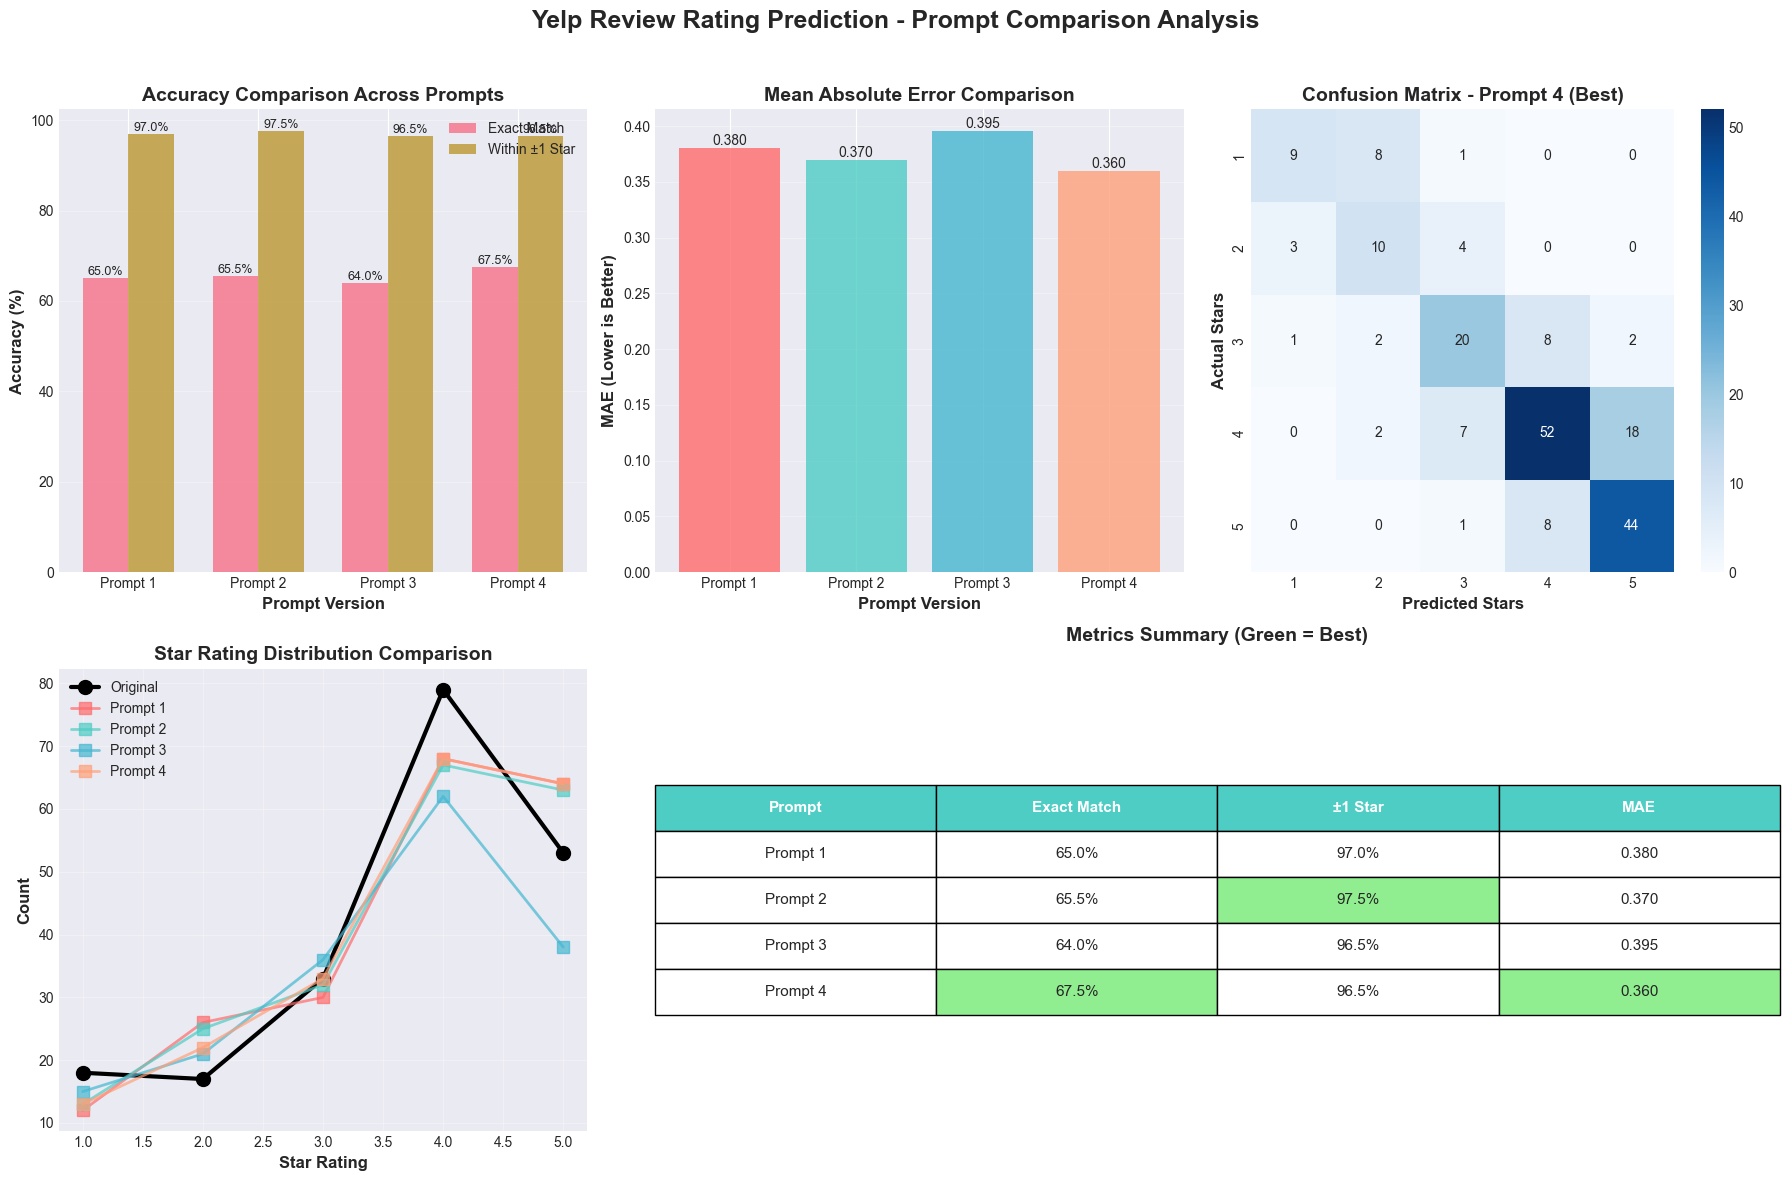

In [22]:
fig = plot_comparison_charts(df_final, df_metrics)

In [23]:
print(f"\nFinal Dataset Shape: {df_final.shape}")
print(f"Total Reviews Processed: {len(df_final)}")
best_idx = df_metrics['exact_match_accuracy'].idxmax()
best_prompt = df_metrics.iloc[best_idx]
print(f"\n{best_prompt['prompt_version']} achieved the best exact match accuracy")
print(f"  Exact Match: {best_prompt['exact_match_accuracy']:.2%}")
print(f"  Within ±1 Star: {best_prompt['within_1_star_accuracy']:.2%}")
print(f"  MAE: {best_prompt['mean_absolute_error']:.3f}")



Final Dataset Shape: (200, 11)
Total Reviews Processed: 200

Prompt 4 achieved the best exact match accuracy
  Exact Match: 67.50%
  Within ±1 Star: 96.50%
  MAE: 0.360
